In [1]:
from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
import gensim

drive.mount('/content/drive')
%cd /content/drive/MyDrive/CMPS6730/project

Mounted at /content/drive
/content/drive/MyDrive/CMPS6730/project


In [2]:
import gensim
from gensim.models import Word2Vec, KeyedVectors
from sklearn.decomposition import PCA
from collections import defaultdict
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import wordnet
import nltk
import gzip


f_in = gzip.open('GoogleNews-vectors-negative300.bin.gz', 'rb')
f_out = open('GoogleNews-vectors-negative300.bin', 'wb')
f_out.writelines(f_in)

In [11]:
import itertools
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.cm as cm
import numpy as np
class Agent:
  def __init__(self, board):
    self.model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=500000)

    nltk.download('wordnet')
    self.past_clues = []
    self.embedding_clusters = []
    self.word_clusters = []

  def generate_clue(self, board):
    new_cands = self.get_neighbors(board)
    final_clues = self.get_clue(new_cands)
    clue = final_clues.pop(0)
    i = 0

    #try to give different clues each time
    while clue in self.past_clues and i < len(final_clues):
      i += 1
      clue = final_clues.pop(i)
      self.past_clues.append(clue)

    return clue

  def get_neighbors(self, board, n_words=15):
    candidate_words = []
    new_cands = []
    syn_dict = {}

    # get neighbors for individual words

    for word in board["Red"]:
      synonyms = self.generate_synonyms(word)
      syn_dict[word] = synonyms

    for words in syn_dict:
      for synonyms in syn_dict[words]:

        try:
          neighbors = self.model.most_similar([synonyms], topn=n_words)
          for word in board["Red"]:
            embeddings = []
            words = []
            for similar_word, _ in neighbors:
                words.append(similar_word)
                embeddings.append(self.model[similar_word])
            self.embedding_clusters.append(embeddings)
            self.word_clusters.append(words)
          candidate_words.extend(neighbors)
        except KeyError:
          pass

    for word, score in candidate_words:
      if any(not c.isalnum() for c in word) or word.upper() in board["Red"]:
        continue
      else:
        new_cands.append((word.lower(), score))


    return sorted(list(set((new_cands))), key=lambda x: x[1], reverse = True)

  def generate_synonyms(self, word):
    synonyms = []
    altered_syn = []
    for syn in wordnet.synsets(word):
        for i in syn.lemmas():
            synonyms.append(i.name().lower())
    for i in synonyms:
      if word.lower() in i or i in word.lower() or "_" in i or "-" in i:
        continue
      else:
        altered_syn.append(i)
    return list(set(altered_syn))

  def get_clue(self, new_cands):

    final_clues = []
    for word, score in new_cands:
      if score >= 0.90:
        final_clues.append((word, 3))
      elif score <= 0.88 and score >= 0.83:
        final_clues.append((word, 2))
      elif score <= 0.83:
        final_clues.append((word,1))

    return final_clues

  def create_embeddings(self):
    embedding_clusters = np.array(self.embedding_clusters)
    n, m, k = embedding_clusters.shape
    tsne_model_en_2d = TSNE(perplexity=45, n_components=2, init='pca', n_iter=3500, random_state=32)
    embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
    return embeddings_en_2d

  def tsne_plot_similar_words(self, title, labels, a, filename=None):
    embedding_clusters = self.create_embeddings()
    word_clusters = self.word_clusters
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]

        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)

    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)

    plt.savefig("plot.pdf")
    plt.show()




In [14]:
import numpy as np
import random

#import pdb
import copy

class Game:
    def __init__(self, words_file):
      self.words_file = words_file
      def gen_board(words_file):
          f = open(words_file, "r")
          board = {}
          temp_array = f.read().splitlines()
          random.shuffle(temp_array)

          board["Red"] = temp_array[:8]
          board["Blue"] = temp_array[8:15]
          board["Civillian"] = temp_array[15:24]
          board["Assasin"]= [temp_array[24]]
          return board

      self.board = gen_board(self.words_file)
      print(self.board)
      self.player = 'red'
      self.blue = self.board["Blue"]
      self.red = self.board["Red"]
      #print(self.red)
      self.assassin = self.board["Assasin"]
      self.neutral = self.board["Civillian"]
      ###agent is red
      self.spymaster = Agent(self.board)
      if self.player == 'blue':
          self.turn_toggle = True
      else:
          self.turn_toggle = False
      return

    #executes the game
    def execute(self):
        print('Let\'s play Codenames')
        print('Your color is: ' + self.player)
        print('the board is:')

        self.show_board()
        while self.blue and self.red and self.assassin:
            if self.turn_toggle:
                print('It\'s your turn; type \"PASS\" to end your turn.')
                self.show_board()
                self.turn()
            else:
                print('It\'s the computer\'s turn:')
                self.opp_turn()
                print('the computer has gone.')

            self.turn_toggle = not self.turn_toggle

        if not self.red:
            print('Red identified all their agents!! They win!!')
        elif not self.blue:
            print('Blue identified all their agents!! They win!!')
        else:
            print('Assassin!! Game over!  ', end = '')
            if self.turn_toggle:
                print('You win!!')
            else:
                print('Computer wins!')
        self.show_board()

    #shows the game board as a dictionary
    def show_board(self):
        board = self.red + self.blue + self.assassin + self.neutral
        random.shuffle(board)
        print(board)


    #execute a full turn for the player
    def turn(self):
        print('Spymaster is generating a clue...')
        print(self.board)
        clue = self.spymaster.generate_clue(self.board)
        print("Your clue is: " + clue[0] + ', ' + str(clue[1]))

        num_guesses = clue[1]
        end = False
        i = 0
        word = ''

        while i < num_guesses and not end and word != 'PASS':
            word = self.guess()
            if word == 'PASS':
                return
            if (word not in self.red):
                print('Your guess was incorrect.  Your turn is over.')
                print()
                end = True
            else:
                print('Correct. You have ' + str(num_guesses-i-1) + ' more guess(es).')
            self.remove_word(word)
            i += 1
        return

    #query a guess from the user
    def guess(self):
        query = input('Guess a word: ')
        print(f"q: {query}")
        if query == 'PASS':
            return query
        while (query not in self.red) and (query not in self.blue) and (query not in self.neutral) and (query not in self.assassin):
            query = input('error: query not in game board. Try again: ')
        return query

    #choose words for the opponent
    def opp_turn(self):
        num = np.random.choice([0,1,2,3], p=[0.2, 0.6, 0.1, 0.1])
        if num == 0:
            self.remove_word(np.random.choice(self.neutral + self.assassin))
            for w in np.random.choice(self.blue, size=min(num, len(self.blue)), replace=False):
                self.remove_word(w)

    #removes a word from the game once it's guessed
    def remove_word(self, word):
        if word in self.blue:
            self.board["Blue"] = [i if i != word else 'BLUE' for i in self.board["Blue"]]
            self.blue.remove(word)
        elif word in self.red:
            self.board["Red"] = [i if i != word else 'RED' for i in self.board["Red"]]
            self.red.remove(word)
        elif word in self.neutral:
            self.board["Civillian"] = [i if i != word else 'NEUTRAL' for i in self.board["Civillian"]]
            self.neutral.remove(word)
        elif word in self.assassin:
            self.board["Assasin"] = [i if i != word else 'ASSASSIN' for i in self.board["Assasin"]]
            self.assassin.remove(word)
        return
    def create_plot(self):
      self.spymaster.generate_clue(self.board)
      self.spymaster.tsne_plot_similar_words('Similar words from Google News', self.red,  0.7)

{'Red': ['SINK', 'HOOD', 'KETCHUP', 'ROBIN', 'TELESCOPE', 'SUB', 'CRASH', 'SPOT'], 'Blue': ['CROSS', 'NOVEL', 'CRICKET', 'POISON', 'GERMANY', 'CHARGE', 'PIT'], 'Civillian': ['YARD', 'SCREEN', 'PITCH', 'CLUB', 'BACK', 'CENTER', 'HEAD', 'NET', 'APPLE'], 'Assasin': ['NAIL']}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-11-142320922b42>:109: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


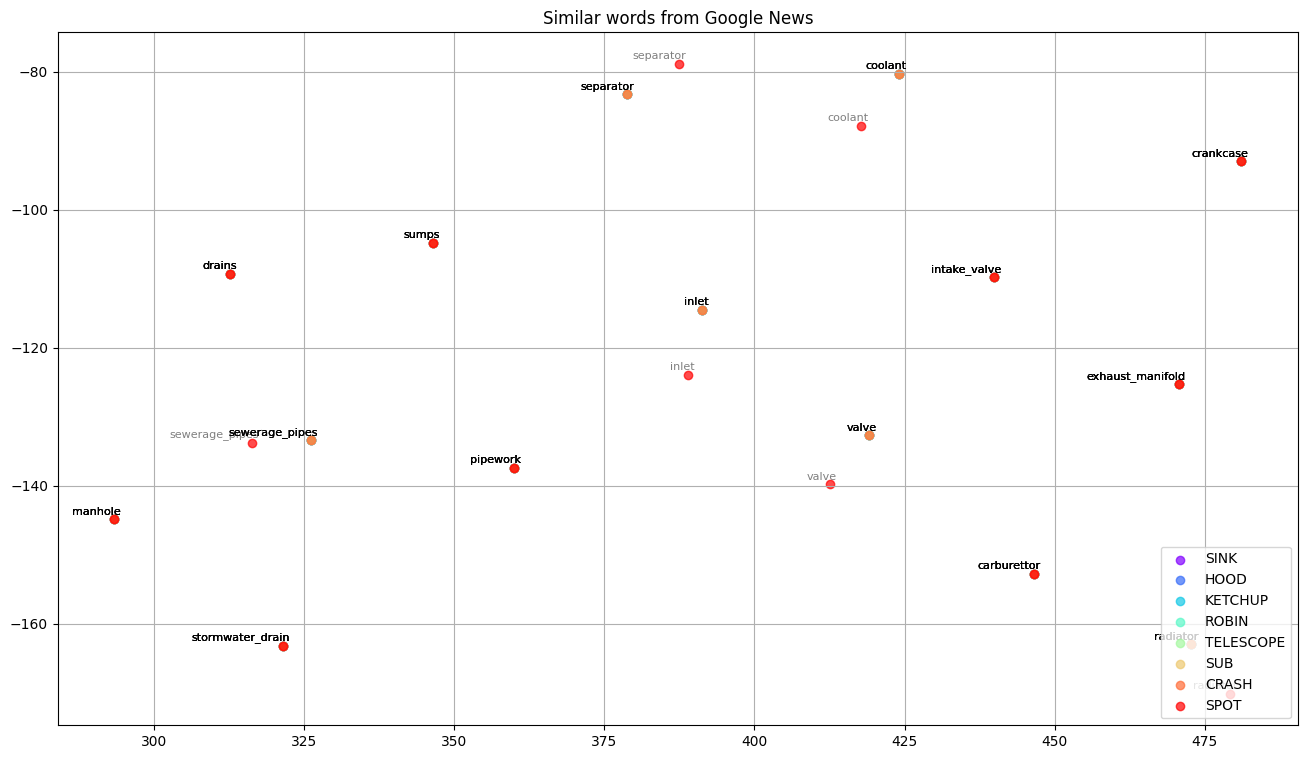

In [15]:
game = Game("game_wordpool.txt")
game.create_plot()


In [ ]:
game2 = Game("game_wordpool.txt")
game2.execute()